# Sentiment Analysis for Financial News
Trong bài tập này, chúng ta sẽ xây dựng một mô hình về Text Classfication dùng để phân loại tình hình tin tức tài chính là tích cực (positive), tiêu cực (negative) hay trung lập (neutral) dựa trên một đoạn văn có nội dung về tài
chính cho trước. Các bạn sẽ thực hiện theo hướng dẫn sau

# 1.Import các thư viện cần thiết

In [2]:
!pip install Unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2.Tải bộ dữ liệu
Các bạn tải bộ dữ liệu tại đây. Ở đây, ta sẽ chỉ quan tâm đến file
all_data.csv. Dưới đây là thông tin 4 hàng đầu tiên của bảng dữ liệu

link: https://drive.google.com/file/d/1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q/view

In [7]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06/W03

/content/drive/MyDrive/Colab Notebooks/MODULE06/W03/data


In [8]:
#!gdown 1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/drive/MyDrive/Colab Notebooks/MODULE06/W03/data/dataset.zip
100% 230k/230k [00:00<00:00, 48.4MB/s]


In [9]:
# unzip data
#!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/all-data.csv    


# 3.Đọc bộ dữ liệu
Sử dụng thư viện pandas, các bạn đọc bộ dữ liệu lên như sau, lưu ý cần phải cài đặt tham số encoding=’ISO-8859-1’ để đưa về định dạng đúng như đoạn code như
sau

In [11]:
%cd /content/drive/MyDrive/Colab Notebooks/MODULE06/W03

/content/drive/MyDrive/Colab Notebooks/MODULE06/W03


In [12]:
dataset_path = 'dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(dataset_path, names=headers, encoding='ISO-8859-1')

In [13]:
df

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [18]:
df.describe()

,sentiment,content
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [16]:
df.columns[0].title


<function str.title()>

In [20]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

Từ đây, ta có thể xác định được danh sách các class của bài toán bằng phương thức unique() của Pandas, đồng thời ta cũng sẽ đổi class dạng string thành số nguyên đại diện cho ID của chúng:

In [21]:
classes = {class_name:idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])

In [22]:
classes

{'neutral': 0, 'negative': 1, 'positive': 2}

In [23]:
df

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,1,LONDON MarketWatch -- Share prices ended lower...
4842,0,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,1,Operating profit fell to EUR 35.4 mn from EUR ...
4844,1,Net sales of the Paper segment decreased to EU...


# 4.Tiền xử lý dữ liệu
Để tận dùng hàm apply của pandas, ta sẽ tiền xử lý văn bản cột content ngay tại đây. Đầu tiên, định nghĩa hàm chuẩn hóa, nhận tham số đầu vào là 1 text và trả về 1 text đã được chuẩn hóa

In [24]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

In [31]:
len(english_stop_words)

179

In [27]:
english_stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [32]:
def text_normalize(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  text = re.sub(r'[^\w\s]', '', text)
  text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])

  return text

Các kỹ thuật chuẩn hóa được áp dụng trong bài bao gồm: Chuyển chữ viết thường (Lowercasing), Xóa dấu câu (Punctuation Removal), Xóa stopwords (Stopwords Removal), Stemming. Sau đó, áp dụng hàm text_normalize() vào cột content

In [33]:
df['content'] = df['content'].apply(lambda x: text_normalize(x))

In [34]:
df

,sentiment,content
0,0,accord gran compani plan move product russia ...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 b...
...,...,...
4841,1,london marketwatch share price end lower lond...
4842,0,rinkuskiai beer sale fell 65 per cent 416 mill...
4843,1,oper profit fell eur 354 mn eur 688 mn 2007 i...
4844,1,net sale paper segment decreas eur 2216 mn sec...


# 5.Xây dựng bộ từ vựng
Để huấn luyện dữ liệu văn bản, ta cần chuyển đổi các văn bản thành vector. Phương thức đơn giản nhất, ta sẽ thu thập toàn bộ các từ trong bộ dữ liệu
thành một tập từ vựng, mỗi từ có một ID riêng. Từ đó, với một văn bản đầu, ta quy đổi sang ID tương ứng, như vậy sẽ được một vector số nguyên. Đoạn code tạo bộ từ vựng được thực hiện như sau:

In [35]:
vocab = []
for sentence in df['content'].tolist():
  tokens = sentence.split()
  for token in tokens:
    if token not in vocab:
      vocab.append(token)

In [39]:
len(vocab)

8906

In [46]:
vocab[:10]

['accord',
 'gran',
 'compani',
 'plan',
 'move',
 'product',
 'russia',
 'although',
 'grow',
 'technopoli']

In [40]:
vocab.append('UNK')
vocab.append('PAD')
word_to_idx = {word:idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

In [43]:
vocab_size

8908

In [42]:
len(word_to_idx)

8908

In [55]:
list(word_to_idx.items())[-10:]

[('tecnomenresult', 8898),
 ('surpris', 8899),
 ('overshadow', 8900),
 ('broader', 8901),
 ('416', 8902),
 ('688', 8903),
 ('2216', 8904),
 ('2411', 8905),
 ('UNK', 8906),
 ('PAD', 8907)]

Trong đó, word_to_idx đại diện cho bộ từ vựng và max_seq_len là một hằng số quy ước độ dài của các văn bản, đảm bảo các văn bản có cùng độ dài.

In [68]:
def transform(text, word_to_idx, max_seq_len):
  tokens = []
  for w in text.split():
    try:
      w_ids = word_to_idx[w]
    except :
      w_ids = word_to_idx['UNK']
    tokens.append(w_ids)

  if len(tokens) < max_seq_len:
    tokens += [word_to_idx['PAD']]*(max_seq_len-len(tokens))
  elif len(tokens) > max_seq_len:
    tokens = tokens[:max_seq_len]

  return tokens

# 6.Chia bộ dữ liệu train, val, test
Ta dùng hàm train_test_split của thư viện scikit-learn để chia bộ dữ liệu thành 3 bộ train/val/test theo tỷ lệ 7:2:1

In [58]:
val_size = 0.2
test_size = 0.125
is_shuffle = True
texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle)

In [60]:
len(texts), len(labels )

(4846, 4846)

In [61]:
X_train[:10]

['joint ventur invest eur 500000 product technolog straight away ',
 'accord rautaruukki  compani want promot use emissionfre energi sourc ',
 'finland  oppohjola staff union boycot group insur sale task compani refus take sale insur account determin wage ',
 'third quarter fiscal 2008 efor swung net loss eur 400000 versu net profit eur 200000 correspond period fiscal 2007 ',
 'altimo previous agre similar deal telenor merg stake vimpelcom kyivstargsm ',
 'agreement jm one seri contract teliasonera sign recent month residenti construct real estat manag compani sweden ',
 'olvi target strengthen market share soft drink  miner water  cider  long drink  energi drink ',
 ' beyond improv voic capabl  custom streamlin way compli recal traceabl requir  provid competit advantag ',
 'accord finnish aktia bank manag director jussi laitinen  bank aim tripl number custom finland next five year ',
 '23 april 2010  finnish construct engin compani outotec oyj hel  ote1v said today slip net loss eur7 

In [62]:
y_train[:10]

[0, 0, 1, 1, 0, 0, 0, 2, 2, 1]

In [63]:
len(X_train), len(y_train)

(3100, 3100)

In [64]:
len(X_val), len(y_val)

(970, 970)

In [65]:
len(X_test), len(y_test)

(776, 776)

# 7.Xây dựng pytorch datasets
Ta triển khai class tên FinancialNews với đầu vào gồm cặp dữ liệu đầu vào X - y, bộ từ điển cũng như hàm transform như sa

In [69]:
class FinancialNews(Dataset):
  def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
    self.texts = X
    self.labels = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]

    if self.transform:
      text = self.transform(text, self.word_to_idx, self.max_seq_len)

    text = torch.tensor(text)

    return text, label

# 8.Khai báo dataloader

In [70]:
max_seq_len = 32
train_dataset = FinancialNews(X_train,
                              y_train,
                              word_to_idx=word_to_idx,
                              max_seq_len=max_seq_len,
                              transform=transform)

val_dataset = FinancialNews(X_val,
                            y_val,
                            word_to_idx=word_to_idx,
                            max_seq_len=max_seq_len,
                            transform=transform)

test_dataset = FinancialNews(X_test,
                             y_test,
                             word_to_idx=word_to_idx,
                             max_seq_len=max_seq_len,
                             transform=transform)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# 9.Xây dựng mô hình
Chúng ta sẽ xây dựng phân loại cảm xúc với 2 layer RNNs. Vector tại hidden state cuối cùng của RNN layer thứ 2 sẽ được đưa vào FC layer để thực hiện dự
đoán. Các bạn có thể quan sát rõ hơn thông qua hình dưới đây

In [71]:
class SentimentClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, n_classes, dropout_prob):
    super(SentimentClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
    self.norm = nn.LayerNorm(hidden_size)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_size, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, n_classes)

  def forward (self, x):
    x = self.embedding(x)
    x, hn = self.rnn(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)

    return x

Ta định nghĩa class với tên SentimentClassifier, nhận tham số đầu vào gồm: kích thước bộ từ vựng (vocab_size), kích thước không gian vector của mỗi từ trong chuỗi đầu vào (embedding_dim), kích thước không gian vector của hidden state (hidden_size), số lượng RNN layer (n_layers), số class dự đoán của bài toán (n_classes) và tỉ lệ dropout (dropout_prob). Với class trên, ta khai báo mô hình SentimentClassifier

In [72]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(vocab_size=vocab_size,
                            embedding_dim=embedding_dim,
                            hidden_size=hidden_size,
                            n_layers=n_layers,
                            n_classes=n_classes,
                            dropout_prob=dropout_prob).to(device)

# 10.Cài đặt hàm loss và optimizer
Ta sử dụng hàm loss crossentropy cho bài toán phân loại và Adam optimizer.

In [73]:
lr = 1e-4
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 11.Thực hiện huấn luyện
Ta định nghĩa hàm fit() và evaluate() dùng để huấn luyện và đánh giá mô hình như sau:

In [74]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
  train_losses = []
  val_losses = []
  for epoch in range(epochs):
    batch_train_losses = []

    model.train()
    for idx, (inputs, labels) in enumerate(train_loader):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())

    train_loss = sum(batch_train_losses)/len(batch_train_losses)
    train_losses.append(train_loss)
    val_loss, val_acc = evaluate(model, val_loader,criterion, device)
    val_losses.append(val_loss)
    print(f'EPOCH{ epoch + 1}:\tTrain loss:{train_loss:.4f}\tVal loss:{val_loss:.4f}')
  return train_losses , val_losses

def evaluate(model, dataloader, criterion, device):
  model.eval()
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels )
      losses.append(loss.item())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()
  loss = sum(losses)/len(losses)
  acc = correct/total
  return loss, acc

Tổng hợp tất cả các dữ kiện trên, ta tiến hành huấn luyện mô hình SentimentClassifier

In [75]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

EPOCH1:	Train loss:1.0049	Val loss:0.9591
EPOCH2:	Train loss:0.9462	Val loss:0.9344
EPOCH3:	Train loss:0.9361	Val loss:0.9299
EPOCH4:	Train loss:0.9320	Val loss:0.9289
EPOCH5:	Train loss:0.9316	Val loss:0.9285
EPOCH6:	Train loss:0.9305	Val loss:0.9282
EPOCH7:	Train loss:0.9274	Val loss:0.9281
EPOCH8:	Train loss:0.9307	Val loss:0.9281
EPOCH9:	Train loss:0.9286	Val loss:0.9280
EPOCH10:	Train loss:0.9340	Val loss:0.9281
EPOCH11:	Train loss:0.9317	Val loss:0.9282
EPOCH12:	Train loss:0.9353	Val loss:0.9279
EPOCH13:	Train loss:0.9335	Val loss:0.9280
EPOCH14:	Train loss:0.9363	Val loss:0.9279
EPOCH15:	Train loss:0.9261	Val loss:0.9278
EPOCH16:	Train loss:0.9285	Val loss:0.9279
EPOCH17:	Train loss:0.9348	Val loss:0.9282
EPOCH18:	Train loss:0.9327	Val loss:0.9276
EPOCH19:	Train loss:0.9350	Val loss:0.9275
EPOCH20:	Train loss:0.9282	Val loss:0.9276
EPOCH21:	Train loss:0.9353	Val loss:0.9277
EPOCH22:	Train loss:0.9292	Val loss:0.9278
EPOCH23:	Train loss:0.9352	Val loss:0.9278
EPOCH24:	Train loss:

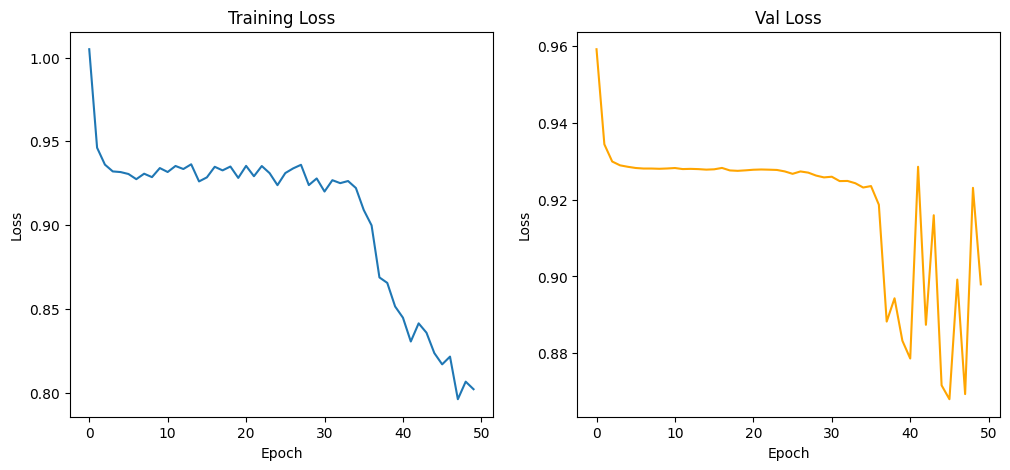

In [76]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

# 12.Đánh giá mô hình
Sử dụng hàm evaluate() đã xây dựng ở trên, ta đánh giá mô hình trên
hai tập val và test như sau

In [77]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print('Evaluation on val / test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val / test dataset
Val accuracy:  0.6144329896907217
Test accuracy:  0.6095360824742269
